In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
# get functions from utils.py
from utils import eval_metrics,plot_train_test,train_data_ml
from joblib import dump
import gc
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.multioutput import MultiOutputRegressor

In [5]:
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])

In [6]:
ili = pd.read_csv("data_ili.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ili = ili.drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [7]:
mape_ari = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])
mape_ili = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])

In [8]:
def rf_variable_selection_and_hyperparam_tuning(train,test,country =None, model_name=None, mape=None):
    X = train.drop(columns=['value','week_mas_1','week_mas_2','week_mas_3'])
    y = train[['value','week_mas_1','week_mas_2','week_mas_3']]

    X_test = test.drop(columns=['value','week_mas_1','week_mas_2','week_mas_3'])
    y_test= test[['value','week_mas_1','week_mas_2','week_mas_3']]
    

    base_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=2332))
    base_rf.fit(X, y)

    importances = np.array([est.feature_importances_ for est in base_rf.estimators_])

    mean_importances = importances.mean(axis=0)


    selected_mask = mean_importances >= 0.01
    selected_features = X.columns[selected_mask].tolist()
    X_selected = X[selected_features]

    # Step 3: Hyperparameter tuning with RandomizedSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rf = RandomForestRegressor(random_state=2332)

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=20,
        cv=tscv,
        n_jobs=-1,
        scoring='neg_mean_absolute_error',
        random_state=2332
    )

    random_search.fit(X_selected, y)

    best_model = random_search.best_estimator_
    model_final = MultiOutputRegressor(best_model)
    model_final.fit(X_selected, y)
    dump(model_final, f"models_rf/rf_model_{country}_{model_name}.joblib")
    test_aux = test.copy()
    prediction_columns = [f"prediction_{h+1}_weeks" for h in range(4)]
    preds = model_final.predict(X_test[selected_features])
    test_aux[prediction_columns] = preds

    # Evaluate predictions
    test_aux = test_aux.dropna()
    mae0, rmse0 = eval_metrics(test_aux["value"], test_aux["prediction_1_weeks"])
    mae1, rmse1  = eval_metrics(test_aux["week_mas_1"], test_aux["prediction_2_weeks"])
    mae2, rmse2  = eval_metrics(test_aux["week_mas_2"], test_aux["prediction_3_weeks"])
    mae3, rmse3 = eval_metrics(test_aux["week_mas_3"], test_aux["prediction_4_weeks"])

    mape = pd.concat([
    mape,
    pd.DataFrame([
        [country, model_name, "1_week", mae0, rmse0],
        [country, model_name, "2_week", mae1, rmse1],
        [country, model_name, "3_week", mae2, rmse2],
        [country, model_name, "4_week", mae3, rmse3]
    ], columns=['location', 'model', 'prediction_window', 'mae', 'rmse'])
], ignore_index=True)
    return model_final, selected_features, test_aux,mape


In [9]:
mape_ari = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])
mape_ili = pd.DataFrame(columns=['location','model','prediction_window','mae','rmse'])

In [10]:
name_ari = ari.location.unique()
name_ili = ili.location.unique()

Processing location: LV


C:\Users\flore\AppData\Local\Temp\ipykernel_2356\2174222648.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


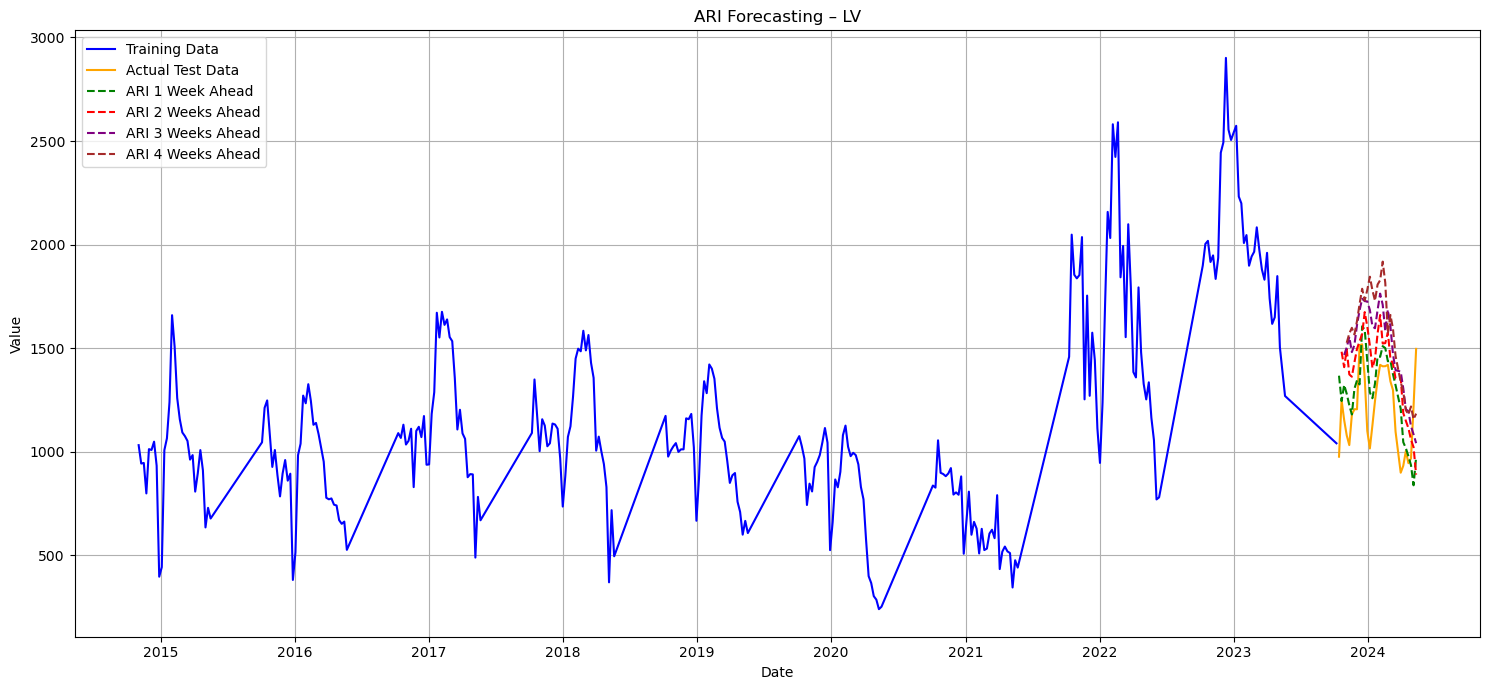

In [11]:
for i in ['LV']:
    print(f"Processing location: {i}")
    train, test = train_data_ml(ari,i, "2023-10-13")
    train = train.drop(columns=['location'])
    test = test.drop(columns=['location'])
    model_final, selected_features, test_aux,mape_ari= rf_variable_selection_and_hyperparam_tuning(train,test,country =i, model_name='ARI', mape=mape_ari)
    plot_train_test(train, test_aux,"ARI",i,'RF')

In [ ]:
mape_ari

In [ ]:
mape_ari.to_csv("mape_ari_rf.csv",index=False)

Processing location: LV


C:\Users\flore\AppData\Local\Temp\ipykernel_2356\2174222648.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape = pd.concat([


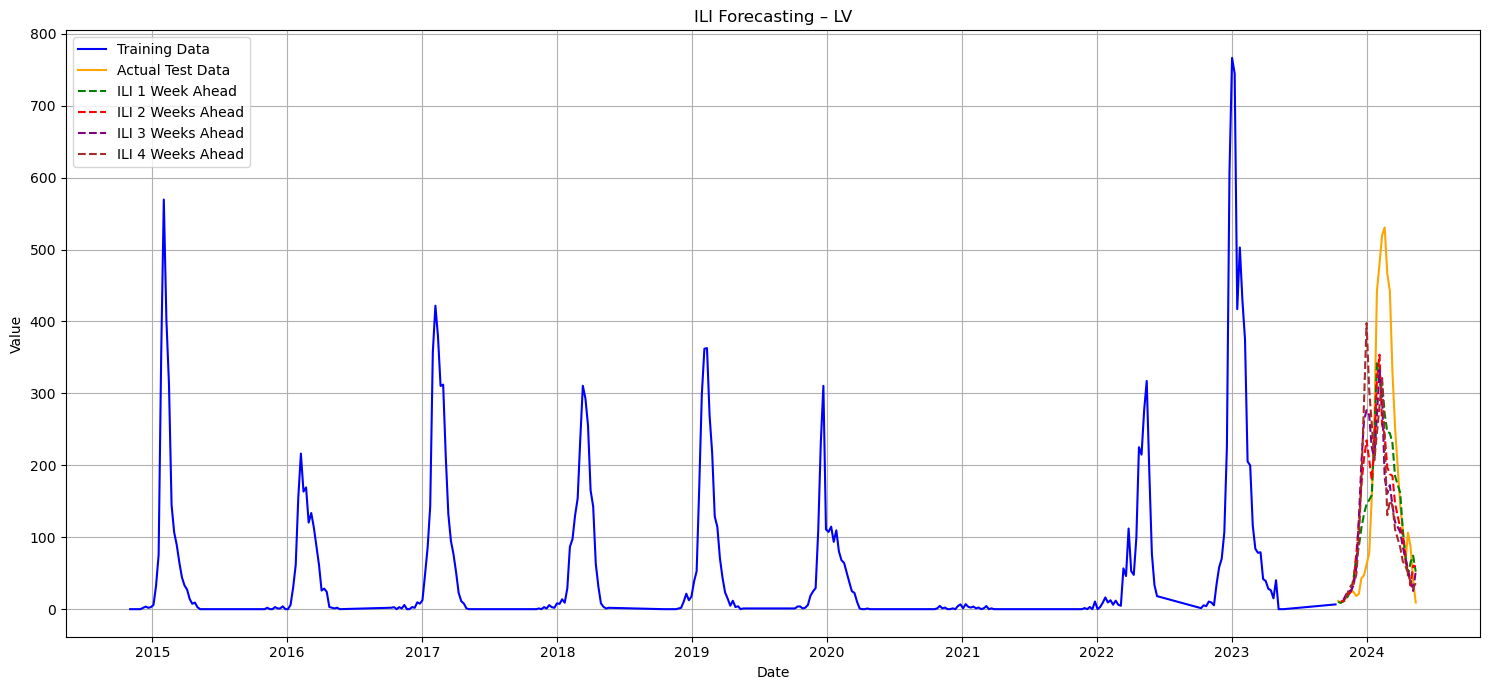

In [12]:
for i in ['LV']:
    print(f"Processing location: {i}")
    train, test = train_data_ml(ili,i, "2023-10-13")
    train = train.drop(columns=['location'])
    test = test.drop(columns=['location'])
    model_final, selected_features, test_aux,mape_ili= rf_variable_selection_and_hyperparam_tuning(train,test,country =i, model_name='ILI', mape=mape_ili)
    plot_train_test(train, test_aux,"ILI",i,'RF')

In [13]:
mape_ili

,location,model,prediction_window,mae,rmse
0,LV,ILI,1_week,66.230940,98.126624
1,LV,ILI,2_week,88.957386,125.071619
2,LV,ILI,3_week,104.374769,144.553708
3,LV,ILI,4_week,112.991675,156.255287


In [ ]:
mape_ili.to_csv("mape_ili_rf.csv",index=False)